In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import sinter
from stim_surface_code.memory import MemoryPatch
from stim_surface_code import noise

In [2]:
m = MemoryPatch(5, 5, 5, id_offset=100)
m

--------------------------------------------------------
|    |    |X125|    |    |    |X126|    |    |    |    |
----------+----+--------------+----+--------------------
|    | 100|    | 101|    | 102|    | 103|    | 104|    |
----------+----+----+----+----+----+----+----+----+-----
|    |    |Z127|    |X128|    |Z129|    |X130|    |Z131|
----------+----+----+----+----+----+----+----+----+-----
|    | 105|    | 106|    | 107|    | 108|    | 109|    |
-----+----+----+----+----+----+----+----+----+----------
|Z132|    |X133|    |Z134|    |X135|    |Z136|    |    |
-----+----+----+----+----+----+----+----+----+----------
|    |L110|    |L111|    |L112|    |L113|    |L114|    |
----------+----+----+----+----+----+----+----+----+-----
|    |    |Z137|    |X138|    |Z139|    |X140|    |Z141|
----------+----+----+----+----+----+----+----+----+-----
|    | 115|    | 116|    | 117|    | 118|    | 119|    |
-----+----+----+----+----+----+----+----+----+----------
|Z142|    |X143|    |Z144|    |

In [3]:
# 10x better noise vals than Google's device
noise_params = noise.GoogleNoiseParams.improve_noise_params(10)

print(noise_params.baseline_error_means)

{'T1': 0.0002, 'T2': 0.00030000000000000003, 'gate1_err': -5.0, 'gate2_err': -3.5, 'readout_err': -2.7}


In [4]:
m.set_error_vals_normal(noise_params.baseline_error_means, noise_params.baseline_error_stdevs)

In [5]:
# We can use Sinter for a single task...
m.count_logical_errors(use_sinter=True)

(0.001122, 10000000)

In [6]:
# ...or we can use Sinter for a batch of tasks
tasks = []
ps = np.linspace(1e-3,1e-2,10)
for d in [3,5,7]:
    m = MemoryPatch(d, d, d)
    for p in np.linspace(5e-4,1e-2,10):
        noise_params = noise.NoiseParams(
            baseline_error_means = {
                'T1': np.inf,
                'T2': np.inf,
                'gate1_err': np.log10(p),
                'gate2_err': np.log10(p),
                'readout_err': np.log10(p),
            }
        )
        m.set_error_vals_normal(noise_params.baseline_error_means)
        tasks.append(m.get_sinter_task(
            task_kwargs={
                'json_metadata': {'d': d, 'p': p},
                'decoder': 'pymatching',
            }
        ))

In [7]:
collected_stats = sinter.collect(tasks=tasks, num_workers=6, max_shots=100_000)

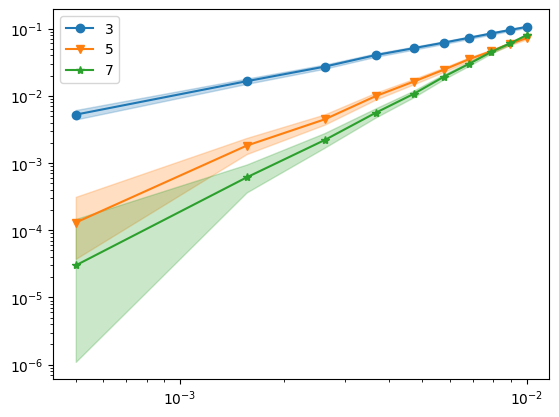

In [8]:
fig,ax = plt.subplots()
sinter.plot_error_rate(ax=ax, stats=collected_stats, x_func=lambda stats: stats.json_metadata['p'], group_func=lambda stats: stats.json_metadata['d'])
ax.legend()
ax.loglog()
plt.show()